In [14]:
variable = '/big/work/mcdevol/simdata_26Nov2023/mcdevol_run/'
latent = np.load(variable + 'latent_mu.npy')
TOTAL_CONTIGS = latent.shape[0]
LATENT_DIMENSION = latent.shape[1]
ETA = 1/ LATENT_DIMENSION
length = np.load(variable + '../contigs_2klength.npz',allow_pickle=True)['arr_0']
contig_names = np.load(variable + '../contigs_2knames.npz',allow_pickle=True)['arr_0']
contig_labels = pd.read_csv(variable + '../contiglabels', sep="\t", header=None)
otu_ids = contig_labels[1]
k_nn = int(TOTAL_CONTIGS ** KUPPA)
p = hnswlib.Index(space = 'l2', dim = 32)
# M - max. number of out-edges ef_construction
# ef_construction - the size of the dynamic list for the nearest neighbors
# and controls index_time/accuracy
p.init_index(max_elements = TOTAL_CONTIGS, ef_construction = 200, M = 16)
p.set_ef(10)
ncpus = os.cpu_count()
p.set_num_threads(ncpus-2 if ncpus is not None else 8)
p.add_items(latent)
labels, distance = p.knn_query(latent, k=k_nn+1)
add_selfindex = np.nonzero(labels.astype(int)[:,0] != np.arange(TOTAL_CONTIGS))[0]
labels[add_selfindex] = np.insert(labels[add_selfindex], 0, add_selfindex, axis=1)[:,:-1]
distance[add_selfindex] = np.insert(distance[add_selfindex], 0, 0.0, axis=1)[:,:-1]
# dc = distance[:,-1]
# lc = length ** ETA
# densities = lc / dc

10 10 7 cluster center counts
10 true cluster counts
Counter({1748: 200, 252: 200, 1577: 200, 1099: 200, 1482: 200, 1572: 200, 270: 200, 1802: 200, 1143: 200, 1817: 200}) nearest counter count
[1143 1572 1482 1748 1099 1802 1577  270  252 1817]
[0 1 2 3 4 5 6 7 8 9]
200 7114.0
200 6914.0
200 6456.0
200 6406.0
200 6046.0
200 6210.0
200 6220.0
200 6532.0
200 6480.0
200 5228.0
Counter({4: 200, 9: 200, 7: 200, 5: 200, 3: 200, 2: 200, 8: 200, 6: 200, 1: 200, 10: 200}) cluster labels
Counter({0: 200, 5: 200, 8: 200, 6: 200, 9: 200, 2: 200, 4: 200, 3: 200, 1: 200, 7: 200}) ground truth


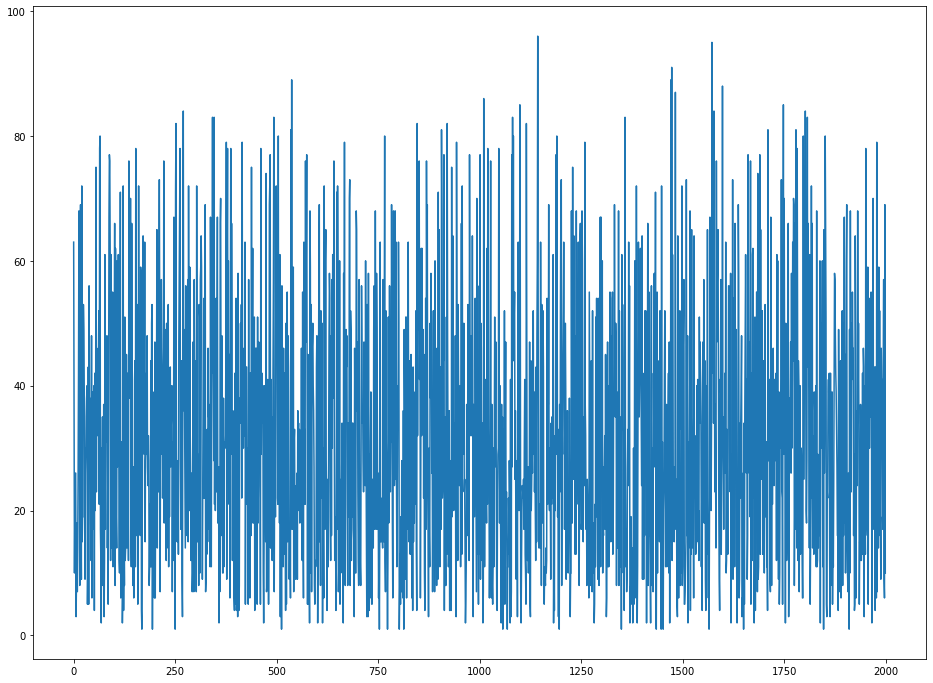

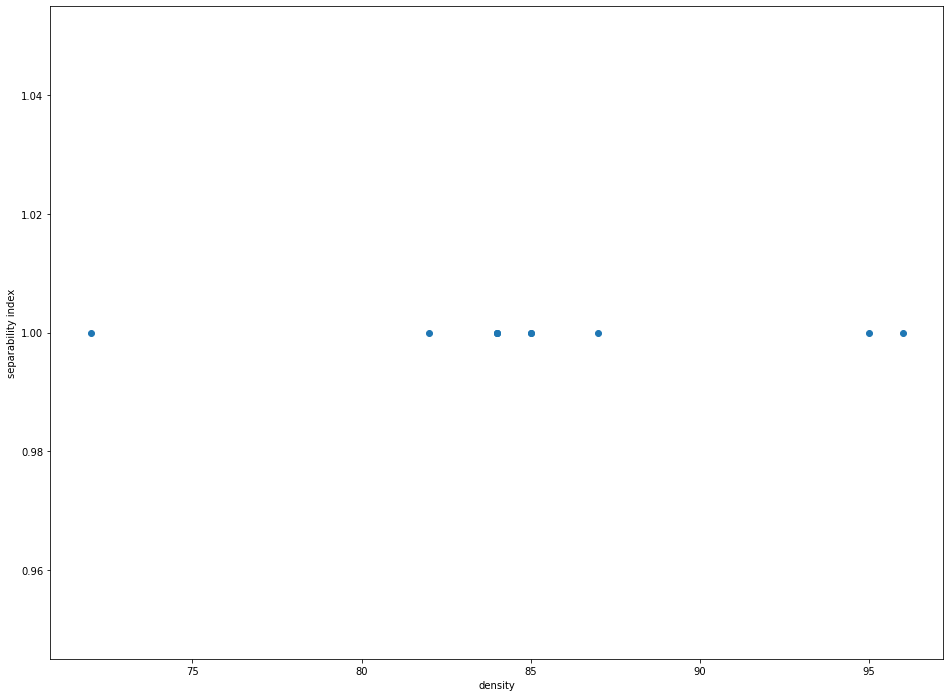

In [141]:
#!/usr/bin/env python

import os
import heapq
import pandas as pd
import numpy as np
import hnswlib
from sklearn.neighbors import KernelDensity


KUPPA = 0.4
TOTAL_CONTIGS = 0
LATENT_DIMENSION = 0
ETA = 0
DISTANCE_CUTOFF = 1
NN_SIZE_CUTOFF = 200000

def add_selfindex(data_indices, labels, distances):
    """ add self index where missed by hnswlib """

    # in case query index does not found as first nearest neighbor,
    # insert manually and remove last nearest neighbor
    add_selfindex = np.nonzero(labels.astype(int)[:,0] != data_indices)[0]
    labels[add_selfindex] = np.insert(labels[add_selfindex], 0, add_selfindex, axis=1)[:,:-1]
    distances[add_selfindex] = np.insert(distances[add_selfindex], 0, 0.0, axis=1)[:,:-1]
    
    return labels, distances

def get_distance_cutoff(p, latent, k_nn, labels, distances, length):
    data_indices = np.arange(TOTAL_CONTIGS)
    cumsum_length = np.cumsum(length[labels], axis=1)
    contigs_with_enough_neighbors = np.nonzero(cumsum_length[:,-1] > NN_SIZE_CUTOFF)[0]
    retry = len(contigs_with_enough_neighbors) / TOTAL_CONTIGS < 0.5
    
    while retry:
        k_nn += 10
        print(k_nn, 'knn')
        labels, distances = p.knn_query(latent, k=k_nn)
        cumsum_length = np.cumsum(length[labels], axis=1)
        contigs_with_enough_neighbors = np.nonzero(cumsum_length[:,-1] > NN_SIZE_CUTOFF)[0]
        retry = len(contigs_with_enough_neighbors) / TOTAL_CONTIGS < 0.5
    labels = labels.astype(int)

    labels, distances = add_selfindex(data_indices, labels, distances)

    dist_cutoff_indices = np.argmax(
            np.cumsum(length[labels], axis=1) > NN_SIZE_CUTOFF, axis=1)
    indices_tofind_dist = np.nonzero(dist_cutoff_indices)[0]
    # for long contigs dist_cutoff_indices would be zero. Hence, add manually
    ind_check_longcontig = np.nonzero(dist_cutoff_indices==0)[0]
    indices_to_add = np.nonzero(length[ind_check_longcontig]>NN_SIZE_CUTOFF)[0]
    indices_tofind_dist = np.concatenate((indices_tofind_dist, \
                                        ind_check_longcontig[indices_to_add]))
    global DISTANCE_CUTOFF
    DISTANCE_CUTOFF = np.median(
        distances[indices_tofind_dist,dist_cutoff_indices[indices_tofind_dist]])
    
    add_moreknn = np.min(distances[:,-1]) < DISTANCE_CUTOFF
    while add_moreknn:
        k_nn += 200
        labels, distances = p.knn_query(latent, k=k_nn+1)
        add_moreknn = np.min(distances[:,-1]) < DISTANCE_CUTOFF
    labels, distances = add_selfindex(data_indices, labels, distances)
    
    return labels, distances


def get_neighbors(latent, length):
    """ compute density using k-nearest neighbors """

    ### get nearest neighbors
    data_indices = np.arange(TOTAL_CONTIGS)
    k_nn = int(TOTAL_CONTIGS ** KUPPA)
    p = hnswlib.Index(space = 'l2', dim = LATENT_DIMENSION)
    
    # M - max. number of out-edges ef_construction
    # ef_construction - the size of the dynamic list for the nearest neighbors
    # and controls index_time/accuracy
    p.init_index(max_elements = TOTAL_CONTIGS, ef_construction = 200, M = 16)
    p.set_ef(10)
    ncpus = os.cpu_count()
    p.set_num_threads(ncpus-2 if ncpus is not None else 8)
    p.add_items(latent)
    labels, distances = p.knn_query(latent, k=k_nn+1)
    
    # in case query index does not its index as first nearest neighbor,
    # insert manually and remove last nearest neighbor
    # add_selfindex = np.nonzero(labels.astype(int)[:,0] != data_indices)[0]
    # labels[add_selfindex] = np.insert(labels[add_selfindex], 0, add_selfindex, axis=1)[:,:-1]
    # distances[add_selfindex] = np.insert(distances[add_selfindex], 0, 0.0, axis=1)[:,:-1]
    
    # dc = distance[:,-1]
    # lc = length ** ETA
    # densities = lc / dc
    
    # labels, distance = get_distance_cutoff(p, latent, k_nn, labels, distance, length)
    add_moreknn = np.min(distances[:,-1]) <= DISTANCE_CUTOFF
    
    while add_moreknn:
        k_nn += 20
        labels, distances = p.knn_query(latent, k=k_nn+1)
        add_moreknn = np.min(distances[:,-1]) <= DISTANCE_CUTOFF
    labels, distances = add_selfindex(data_indices, labels, distances)

    return labels, distances

def get_density_peaks(labels, distances, length):

    densities = np.zeros(TOTAL_CONTIGS)

    # Create a mask for distances less than DISTANCE_CUTOFF
    mask = distances <= DISTANCE_CUTOFF

    # Apply the mask to nn_inds_k
    filtered_inds = np.where(mask, labels, -1).astype(int)  # Using -1 as a placeholder for invalid indices

    # Initialize densities array
    valid_indices = []
    for c in range(TOTAL_CONTIGS):
        valid_inds = filtered_inds[c, filtered_inds[c] >= 0]
        valid_indices.append(valid_inds)
        densities[c] = len(valid_inds) # np.sum(length[valid_inds] ** ETA) / DISTANCE_CUTOFF

    density_peaks_flag = np.full(TOTAL_CONTIGS,-1)

    graph = {}
    nearest = np.arange(TOTAL_CONTIGS)
    for c, inds in enumerate(valid_indices):
        # single member clusters
        if inds.size == 1:
            # print(densities[inds], 'densities of single member', c)
            if densities[inds] > 1: # long genomic contig as a single cluster
                density_peaks_flag[c] = c
                graph[c] = []
                nearest[c] = c
            else: # short isolated contig
                # maxdens_neighbor = np.argmax(densities[labels[c]])
                # if distances[c][maxdens_neighbor] <= DISTANCE_CUTOFF * 1.5 :
                #     graph[c] = labels[c][maxdens_neighbor]
                #     nearest[c] = labels[c][maxdens_neighbor]
                # else:
                #     graph[c] = []
                #     nearest[c] = labels[c][1]
        
                nearest_points = np.nonzero(distances[c] <= DISTANCE_CUTOFF * 1.5)[0]
                if nearest_points.size > 1:
                    maxdens_neighbor1 = nearest_points[np.argmax(densities[labels[c][nearest_points]])]
                    graph[c] = labels[c][maxdens_neighbor1]
                    nearest[c] = labels[c][maxdens_neighbor1]
                else:
                    
                    graph[c] = []
                    nearest[c] = labels[c][1]

            continue
        
        max_densityindex = inds[np.argmax(densities[inds])]
        # inds all can have the same density but small. They become separate low-density peaks
        # To Do: have to solve to merge such low-density peaks with higher density peaks
        if c == max_densityindex:
            density_peaks_flag[c] = c
            nearest[c] = c
        else:
            nearest[c] = max_densityindex
            
        graph[c] = list(zip(inds[1:], densities[inds[1:]]))

    density_peaks_inds = np.nonzero(density_peaks_flag>=0)[0]
    
    peak_count = int(TOTAL_CONTIGS ** (1-KUPPA))

    if peak_count > len(density_peaks_inds): 
        peak_count = len(density_peaks_inds)
    
    get_inds = np.argsort(densities[density_peaks_inds])[::-1][:peak_count]
    density_peaks = density_peaks_inds[get_inds]

    outlier_points = density_peaks[remove_outliers_peaks(densities[density_peaks])]
    # print(densities[outlier_points], outlier_points,  'outlier')

    # for f in outlier_points:
    #     print(f, distances[f], filtered_inds[f], valid_indices[f], densities[labels[f]])

    # print(len(density_peaks), 'length of density peaks')
    # # print(density_peaks, len(density_peaks), densities[density_peaks] ,'density peaks')

    plt.figure(figsize=(16,12))
    plt.plot(densities)

    return densities, density_peaks, graph, nearest

def dijkstra_max_min_density(graph, start):
    """ return max density path between start and nearest neighbors """    
    
    # Initialize maximum minimum densities and priority queue
    max_min_densities = {node: float('-inf') for node in graph}
    max_min_densities[start] = float('inf')
    priority_queue = [(-max_min_densities[start], start)]  # Priority queue of (negative density, node)

    while priority_queue:
        # Extract node with highest maximum minimum density
        current_density, current_node = heapq.heappop(priority_queue)
        current_density = -current_density

        for neighbor, density in graph[current_node]:
            # Calculate new maximum minimum density for neighbor
            new_density = min(current_density, density)
            if new_density > max_min_densities[neighbor]:
                max_min_densities[neighbor] = new_density

                heapq.heappush(priority_queue, (-new_density, neighbor))

    return max_min_densities

def find_connected_components(merge_links):

    K = len(merge_links)
    merge_sets = np.zeros(K).astype(int) - 1
    merge_curr = 0
    for k in np.arange(K):

        if merge_sets[k] < 0:

            candidates = merge_links[k]

            merge_sets[k] = merge_curr

            while len(candidates) != 0:
                l = candidates.pop(-1)

                if merge_sets[l] < 0:
                    merge_sets[l] = merge_curr
                    candidates.extend(merge_links[l])

            merge_curr += 1


    if (merge_curr != len(set(merge_sets))):
        raise Exception("problem with connected component calculations")
        exit(0)

    num_sets = merge_curr
    numclust_insets = np.unique(merge_sets, return_counts=True)[1]

    return merge_sets

def remove_outliers_peaks(data, m=2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / (mdev if mdev else 1.)
    return np.where(s < m)[0] # indices of outlier points

def cluster(latent, contig_length):
    """ cluster contigs """

    labels, distances = get_neighbors(latent, contig_length)
    densities, density_peaks, graph, nearest = get_density_peaks(labels, distances, contig_length)
    separability_indices = np.full(len(density_peaks), 1.0, dtype=np.float32)

    merge_links = []
    for i, peak in enumerate(density_peaks):
        max_min_densities = dijkstra_max_min_density(graph, peak)

        higherdensity_links = {k:v for k, v in max_min_densities.items() if (k in density_peaks) and (k != peak) and (v != float('-inf'))}
        # higherdensity_links = {k:v for k, v in higherdensity_links.items() if v > densities[peak]} # this doesn't work when v and densities[peak] is same value
        if higherdensity_links:
            # print(peak, higherdensity_links)
            max_key = max(higherdensity_links, key=higherdensity_links.get)
            separability_indices[i] = 1 - (higherdensity_links[max_key] / densities[peak])
            merge_peakinds = np.where(np.isin(density_peaks, list(higherdensity_links.keys())))[0]
            merge_links.append([i] + list(merge_peakinds))
        else:
            merge_links.append([])
    
    # not useful for deciding number of clusters and assignment as we have merging of density peaks
    plt.figure(figsize=(16,12))
    plt.scatter(densities[density_peaks], separability_indices)
    plt.xlabel('density')
    plt.ylabel('separability index')

    separability_indices = np.sort(separability_indices)[::-1]

    cluster_centercounts = np.argmax(np.abs(np.diff(separability_indices))) + 1
    if cluster_centercounts == 1:
        cluster_centercounts = len(density_peaks)

    print(len(density_peaks), cluster_centercounts, len(remove_outliers_peaks(densities[density_peaks])), 'cluster center counts')
    
    # print(len(separability_indices), len(density_peaks))
    # cluster_centers = density_peaks[densities[density_peaks] > int(TOTAL_CONTIGS ** KUPPA)] # density_peaks[:cluster_centercounts]
    ##################################

    # for f in density_peaks[cluster_centercounts:]:
    #     max_min_densities = dijkstra_max_min_density(graph, f)
    #     higherdensity_links = {k:v for k, v in max_min_densities.items() if (k in density_peaks) and (k != f) and (v != float('-inf'))}    
    #     print(f, higherdensity_links)
    # density_peaks = density_peaks[:cluster_centercounts]
    
    merge_sets = find_connected_components(merge_links)
    print(len(set(merge_sets)), 'true cluster counts')


    return densities, density_peaks, merge_sets, nearest, cluster_centercounts


def assign_points(density_peaks, merge_sets, nearest, densities):
    """ assign points to density peaks and merge closer density peaks """
    nearest[density_peaks] = density_peaks

    nearest_prev = np.zeros(nearest.size, dtype=int) - 1

    while (nearest != nearest_prev).any():
        nearest_prev = nearest
        nearest = nearest[nearest[nearest[nearest[:]]]]

    components = []
 
    for k in range(len(density_peaks)):
        
        if len((np.argwhere(nearest == density_peaks[k])[0])) > 0:
            components.append(np.nonzero(nearest == density_peaks[k])[0])

        else:
            raise RuntimeWarning("no clusters in cluster_centers[k] is assigned to nearest[k]")

    clusters = []

    print(Counter(nearest), 'nearest counter count')
    print(density_peaks)
    print(merge_sets)
    for i in set(merge_sets):
        merge_indices = np.nonzero(merge_sets == i)[0]
        merge_temp = []
        for j in merge_indices:
            merge_temp.extend(components[j])
        clusters.append(merge_temp)
    for f in clusters:
        print(len(f), sum(densities[f]))
    return clusters, components

if __name__ == "__main__":

    # variable = '/big/work/mcdevol/simdata_26Nov2023/mcdevol_run/'
    # latent = np.load(variable + 'latent_mu.npy')
    # TOTAL_CONTIGS = latent.shape[0]
    # LATENT_DIMENSION = latent.shape[1]
    # ETA = 1 / LATENT_DIMENSION
    # contig_length = np.load(variable + '../contigs_2klength.npz',allow_pickle=True)['arr_0']
    # contig_names = np.load(variable + '../contigs_2knames.npz',allow_pickle=True)['arr_0']
    # contig_labels = pd.read_csv(variable + '../contiglabels', sep="\t", header=None)
    # otu_ids = contig_labels[1]
    # separability_indices = cluster(latent, contig_length)

    from sklearn.datasets import make_blobs
    import matplotlib.pyplot as plt
    import pandas as pd
    from scipy.spatial import distance_matrix

    latent, true_clusters = make_blobs(n_samples = 2000,
                    n_features = 5, 
                    centers = 10,
                    cluster_std = 0.5,
                    shuffle = True)

    TOTAL_CONTIGS = latent.shape[0]
    LATENT_DIMENSION = latent.shape[1]
    ETA = 1 / LATENT_DIMENSION
    contig_length = np.full(TOTAL_CONTIGS, 1, dtype=int)
    densities, density_peaks, merge_sets, nearest, cluster_centercounts = cluster(latent, contig_length)
    clusters, components = assign_points(density_peaks, merge_sets, nearest, densities)
    labels = np.zeros(TOTAL_CONTIGS,dtype=int)

    counter = 1
    for i in range(len(clusters)):
        labels[clusters[i]] = counter
        counter += 1

    from collections import Counter
    print(Counter(labels), 'cluster labels')
    print(Counter(true_clusters), 'ground truth')
    
    import seaborn as sns
    import plotly.express as px
    fig = px.scatter(x=latent[:,0], y=latent[:,1], color=labels)
    fig.update_traces(marker=dict(size=5))
    fig.show()

    fig1 = px.scatter(x=latent[:,0], y=latent[:,1], color=true_clusters)
    fig1.update_traces(marker=dict(size=5))
    fig1.show()
